In [1]:
import pandas as pd
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math

train = pd.read_csv('../input/tabular-playground-series-jan-2022/train.csv',index_col='row_id')
test = pd.read_csv('../input/tabular-playground-series-jan-2022/test.csv',index_col='row_id')

train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

train['dayofweek'] = train['date'].dt.dayofweek
test['dayofweek'] = test['date'].dt.dayofweek

In [2]:
gdp_df = pd.read_csv('../input/gdp-20152019-finland-norway-and-sweden/GDP_data_2015_to_2019_Finland_Norway_Sweden.csv')
gdp_df.set_index('year', inplace=True)

In [3]:
data = pd.concat([train, test], axis=0, ignore_index=True)

In [4]:
import holidays
holiday_FI = holidays.CountryHoliday('FI', years=[2015, 2016, 2017, 2018, 2019])
holiday_NO = holidays.CountryHoliday('NO', years=[2015, 2016, 2017, 2018, 2019])
holiday_SE = holidays.CountryHoliday('SE', years=[2015, 2016, 2017, 2018, 2019])
holiday_dict = holiday_FI.copy()
holiday_dict.update(holiday_NO)
holiday_dict.update(holiday_SE)

data['date'] = pd.to_datetime(data['date']) 
data['holiday_name'] = data['date'].map(holiday_dict)
data['is_holiday'] = np.where(data['holiday_name'].notnull(), 1, 0)

In [5]:
import dateutil.easter as easter
def engineer(df):
    
    gdp_exponent = 1.2121103201489674
    def get_gdp(row):
        country = 'GDP_' + row.country
        return gdp_df.loc[row.date.year, country]
    
    temp = pd.DataFrame(df.apply(get_gdp, axis=1))
    df['GDP'] = temp
    
    """Return a new dataframe with the engineered features"""
    # Easter
    easter_date = df.date.apply(lambda date: pd.Timestamp(easter.easter(date.year)))
    df['days_from_easter'] = (df.date - easter_date).dt.days.clip(-5, 65)
    
    # Last Sunday of May (Mother's Day)
    sun_may_date = df.date.dt.year.map({2015: pd.Timestamp(('2015-5-31')),
                                         2016: pd.Timestamp(('2016-5-29')),
                                         2017: pd.Timestamp(('2017-5-28')),
                                         2018: pd.Timestamp(('2018-5-27')),
                                         2019: pd.Timestamp(('2019-5-26'))})
    #new_df['days_from_sun_may'] = (df.date - sun_may_date).dt.days.clip(-1, 9)
    
    # Last Wednesday of June
    wed_june_date = df.date.dt.year.map({2015: pd.Timestamp(('2015-06-24')),
                                         2016: pd.Timestamp(('2016-06-29')),
                                         2017: pd.Timestamp(('2017-06-28')),
                                         2018: pd.Timestamp(('2018-06-27')),
                                         2019: pd.Timestamp(('2019-06-26'))})
    df['days_from_wed_jun'] = (df.date - wed_june_date).dt.days.clip(-5, 5)
    
    # First Sunday of November (second Sunday is Father's Day)
    sun_nov_date = df.date.dt.year.map({2015: pd.Timestamp(('2015-11-1')),
                                         2016: pd.Timestamp(('2016-11-6')),
                                         2017: pd.Timestamp(('2017-11-5')),
                                         2018: pd.Timestamp(('2018-11-4')),
                                         2019: pd.Timestamp(('2019-11-3'))})
    df['days_from_sun_nov'] = (df.date - sun_nov_date).dt.days.clip(-1, 9)
    
    return df


data = engineer(data)

In [6]:

from sklearn import preprocessing, metrics

cat = ['country', 'store', 'product', 'holiday_name']
for feature in cat:
    encoder = preprocessing.LabelEncoder()
    data[feature] = data[feature].astype('str') 
    data[feature] = encoder.fit_transform(data[feature])
    
data['year'] = data['date'].dt.year 
data['quarter'] = data['date'].dt.quarter
data['month'] = data['date'].dt.month  
data['week'] = data['date'].dt.week 
data['day'] = data['date'].dt.day  
data['weekday'] = data['date'].dt.weekday
data['dayofweek'] = data['date'].dt.dayofweek  
data['dayofyear'] = data['date'].dt.dayofyear  
data['weekofyear'] = data['date'].dt.weekofyear
data['dayofmonth'] = data['date'].dt.days_in_month  
data['is_weekend'] = np.where((data['weekday'] == 5) | (data['weekday'] == 6), 1, 0)
data['is_Firday'] = np.where((data['weekday'] == 4), 1, 0)

labels = list(data.columns.values)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


In [7]:
train = data[data['date'] <= '2017-12-31']
# delete row_id 、date 、country_store_product_id、num_sold
feature = [
 'country',
 'store',
 'product',
 'holiday_name',
 'is_holiday',
     'GDP',
    'days_from_easter',
 'days_from_wed_jun',
 'days_from_sun_nov',
 'year',
 'quarter',
 'month',
 'week',
 'day',
 'weekday',
 'dayofweek',
 'dayofyear',
 'weekofyear',
 'dayofmonth',
 'is_weekend',
 'is_Firday']
x_train = train[feature]
y_train = np.log(train['num_sold'] / train['GDP'])
# one year to vaild
val = data[(data['date'] > '2017-12-31') & (data['date'] <= '2018-12-31')]
x_val = val[feature]
y_val = np.log(val['num_sold'] / val['GDP'])
# one year to test
test = data[(data['date'] > '2018-12-31')]
x_test = test[feature]
x_train

,country,store,product,holiday_name,is_holiday,GDP,days_from_easter,days_from_wed_jun,days_from_sun_nov,year,...,month,week,day,weekday,dayofweek,dayofyear,weekofyear,dayofmonth,is_weekend,is_Firday
0,0,0,1,18,1,234.440,-5,-5,-1,2015,...,1,1,1,3,3,1,1,31,0,0
1,0,0,0,18,1,234.440,-5,-5,-1,2015,...,1,1,1,3,3,1,1,31,0,0
2,0,0,2,18,1,234.440,-5,-5,-1,2015,...,1,1,1,3,3,1,1,31,0,0
3,0,1,1,18,1,234.440,-5,-5,-1,2015,...,1,1,1,3,3,1,1,31,0,0
4,0,1,0,18,1,234.440,-5,-5,-1,2015,...,1,1,1,3,3,1,1,31,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19723,2,0,0,17,1,541.019,65,5,9,2017,...,12,52,31,6,6,365,52,31,1,0
19724,2,0,2,17,1,541.019,65,5,9,2017,...,12,52,31,6,6,365,52,31,1,0
19725,2,1,1,17,1,541.019,65,5,9,2017,...,12,52,31,6,6,365,52,31,1,0
19726,2,1,0,17,1,541.019,65,5,9,2017,...,12,52,31,6,6,365,52,31,1,0


In [8]:
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import mean_squared_error

def SMAPE(y_true, y_pred):
    denominator = (y_true + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.mean(diff)

data_train = xgb.DMatrix(x_train, y_train)
data_val = xgb.DMatrix(x_val, y_val)

paras = {
        'tree_method':'gpu_hist',
        'grow_policy' : 'lossguide',
        'learning_rate': 0.03399878704233446,
        'max_depth': 5,
        'reg_alpha': 0.7814373604498039,
        'reg_lambda': 0.00018093104956619317,
        'max_delta_step': 2,
        'min_child_weight': 14,
        'colsample_bytree': 0.6489299778623602,
        'subsample': 0.6033298718112065,
        'max_leaves': 187,  
        }
watchlist = [(data_train,'train'),(data_val,'val')]
n_round = 20000
model = xgb.train(dict(paras),data_train,num_boost_round = n_round,evals = watchlist,
                                 early_stopping_rounds=8000)


data_test = xgb.DMatrix(x_test)  
y_sub_1 = model.predict(data_test)

data_val_test = xgb.DMatrix(x_val)
y_val_hat_1 = model.predict(data_val_test) 
mean_squared_error_all = mean_squared_error(y_val, y_val_hat_1) 
print(f'mean_squared_error_all: {mean_squared_error_all}')
print(f'SMAPE: {SMAPE(np.exp(y_val)* x_val.GDP.values, np.exp(y_val_hat_1)* x_val.GDP.values)}')

fold_importance_df = pd.DataFrame()
fold_importance_df["feature"] = model.get_score().keys()
fold_importance_df["importance"] = model.get_score().values()  

[0]	train-rmse:0.93666	val-rmse:0.92579
[1]	train-rmse:0.90583	val-rmse:0.89495
[2]	train-rmse:0.88480	val-rmse:0.87399
[3]	train-rmse:0.85565	val-rmse:0.84484
[4]	train-rmse:0.83628	val-rmse:0.82554
[5]	train-rmse:0.82011	val-rmse:0.80958
[6]	train-rmse:0.80250	val-rmse:0.79214
[7]	train-rmse:0.77616	val-rmse:0.76580
[8]	train-rmse:0.75073	val-rmse:0.74037
[9]	train-rmse:0.72618	val-rmse:0.71583
[10]	train-rmse:0.71256	val-rmse:0.70230
[11]	train-rmse:0.69084	val-rmse:0.68060
[12]	train-rmse:0.66835	val-rmse:0.65812
[13]	train-rmse:0.64664	val-rmse:0.63642
[14]	train-rmse:0.63504	val-rmse:0.62493
[15]	train-rmse:0.61599	val-rmse:0.60591
[16]	train-rmse:0.60539	val-rmse:0.59547
[17]	train-rmse:0.59535	val-rmse:0.58557
[18]	train-rmse:0.57610	val-rmse:0.56635
[19]	train-rmse:0.56680	val-rmse:0.55719
[20]	train-rmse:0.55023	val-rmse:0.54078
[21]	train-rmse:0.53545	val-rmse:0.52615
[22]	train-rmse:0.52723	val-rmse:0.51809
[23]	train-rmse:0.51943	val-rmse:0.51043
[24]	train-rmse:0.50461	va

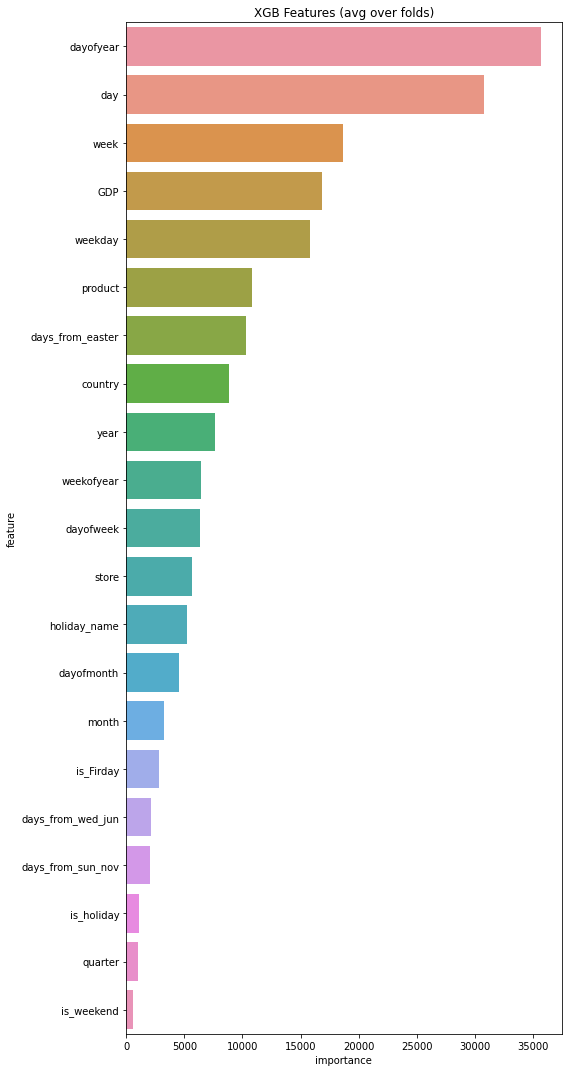

In [9]:
N = 30 # TOP N
cols = (fold_importance_df[["feature", "importance"]] .groupby("feature").mean().sort_values(by="importance", ascending=False)[:N].index)
best_features = fold_importance_df.loc[fold_importance_df.feature.isin(cols)].sort_values(by='importance',ascending=False)

plt.figure(figsize=(8, 15))
sns.barplot(y="feature", x="importance",data=best_features.sort_values(by="importance", ascending=False))
plt.title('XGB Features (avg over folds)')
plt.tight_layout()
plt.savefig('Xgb_importances_weight.png')

In [10]:
data_train = lgb.Dataset(x_train, y_train)
data_val = lgb.Dataset(x_val, y_val)
# param = {
#         'boosting_type': 'gbdt',
#         'metric': 'rmse',
#         'n_jobs': -1,
#         'seed': 2021,
#         'learning_rate': 0.045,
#         'bagging_fraction': 0.75,
#         'bagging_freq': 10,
#         'colsample_bytree': 0.75,
#         'num_leaves': 69,
# }

# CV
param = {
        'objective': 'regression',
         'force_row_wise': True,
         'max_bin': 400,
         'verbosity': -1,
         'seed': 1,
         'bagging_seed': 10,
         'feature_fraction_seed': 2,
         'learning_rate': 0.019157894736842106,
         'lambda_l1': 0,
         'lambda_l2': 0.01,
         'num_leaves': 22,
         'feature_fraction': 0.6689655172413793,
         'bagging_fraction': 0.4275862068965517,
         'bagging_freq': 6,
         'min_child_samples': 18,
}

watchlist = [data_train, data_val]
n_round = 20000
model = lgb.train(dict(param), data_train, num_boost_round=n_round, valid_sets=watchlist,early_stopping_rounds=8000)


data_test = x_test
y_sub_2 = model.predict(data_test)

data_val_test = x_val
y_val_hat_2 = model.predict(data_val_test) 
mean_squared_error_all = mean_squared_error(y_val, y_val_hat_2)  

print(f'mean_squared_error_all: {mean_squared_error_all}')
print(f'SMAPE: {SMAPE(np.exp(y_val)* x_val.GDP.values, np.exp(y_val_hat_2)* x_val.GDP.values)}')

fold_importance_df2 = pd.DataFrame()
fold_importance_df2["feature"] = model.feature_name()
fold_importance_df2["importance"] = model.feature_importance()  

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	training's l2: 0.44156	valid_1's l2: 0.444634
Training until validation scores don't improve for 8000 rounds
[2]	training's l2: 0.425806	valid_1's l2: 0.428849
[3]	training's l2: 0.410635	valid_1's l2: 0.413655
[4]	training's l2: 0.396023	valid_1's l2: 0.398995
[5]	training's l2: 0.381967	valid_1's l2: 0.38489
[6]	training's l2: 0.370471	valid_1's l2: 0.373411
[7]	training's l2: 0.364867	valid_1's l2: 0.367749
[8]	training's l2: 0.359534	valid_1's l2: 0.362397
[9]	training's l2: 0.346768	valid_1's l2: 0.349579
[10]	training's l2: 0.334523	valid_1's l2: 0.337316
[11]	training's l2: 0.322744	valid_1's l2: 0.325518
[12]	training's l2: 0.31804	valid_1's l2: 0.320758
[13]	training's l2: 0.308429	valid_1's l2: 0.311107
[14]	training's l2: 0.297622	valid_1's l2: 0.300283
[15]	training's l2: 0.293381	valid_1's l2: 0.296
[16]	training's l2: 0.283114	valid_1's l2: 0.285682
[17]	training's l2: 0.27325	valid_1's l2: 0.275801
[18]	training's l2: 0.26512	valid_1's l2: 0.267666
[19]	training's l2

In [11]:
y_sub_1_all = np.exp(y_sub_1) * x_test['GDP'].values
y_sub_2_all = np.exp(y_sub_2) * x_test['GDP'].values

sub1 = y_sub_1_all * 0.3 + y_sub_2_all *  0.7    # PubV2-4--
sub2 = y_sub_1_all * 0.2 + y_sub_2_all *  0.8  # PubV2-5--
sub3 = y_sub_1_all * 0.4 + y_sub_2_all *  0.6  # PubV2-6--

In [12]:
sample_submit = pd.read_csv('../input/tabular-playground-series-jan-2022/sample_submission.csv')
# sample_submit['num_sold'] = sub1
# sample_submit['num_sold'] = np.round(sample_submit['num_sold']).astype(int) 
# # sample_submit.to_csv('submission.csv', index=False)


# sample_submit['num_sold'] = sub2
# sample_submit['num_sold'] = np.round(sample_submit['num_sold']).astype(int) 
# sample_submit.to_csv('submission.csv', index=False)

sample_submit['num_sold'] = sub3
sample_submit['num_sold'] = np.round(sample_submit['num_sold']).astype(int) 
sample_submit.to_csv('submission.csv', index=False)

In [13]:
# def engineer(df):
#     """Return a new dataframe with the engineered features"""
#     gdp_exponent = 1.2121103201489674
#     def get_gdp(row):
#         country = 'GDP_' + row.country
#         return gdp_df.loc[row.date.year, country]
        
#     new_df = pd.DataFrame({'gdp': np.log(df.apply(get_gdp, axis=1)),
#                            'wd4': df.date.dt.weekday == 4, # Friday
#                            'wd56': df.date.dt.weekday >= 5, # Saturday and Sunday
#                           })

#     # One-hot encoding (no need to encode the last categories)
#     for country in ['Finland', 'Norway']:
#         new_df[country] = df.country == country
#     new_df['KaggleRama'] = df.store == 'KaggleRama'
#     for product in ['Kaggle Mug', 'Kaggle Hat']:
#         new_df[product] = df['product'] == product
        
#     # Seasonal variations (Fourier series)
#     # The three products have different seasonal patterns
#     dayofyear = df.date.dt.dayofyear
#     for k in range(1, 3):
#         new_df[f'sin{k}'] = np.sin(dayofyear / 365 * 2 * math.pi * k)
#         new_df[f'cos{k}'] = np.cos(dayofyear / 365 * 2 * math.pi * k)
#         new_df[f'mug_sin{k}'] = new_df[f'sin{k}'] * new_df['Kaggle Mug']
#         new_df[f'mug_cos{k}'] = new_df[f'cos{k}'] * new_df['Kaggle Mug']
#         new_df[f'hat_sin{k}'] = new_df[f'sin{k}'] * new_df['Kaggle Hat']
#         new_df[f'hat_cos{k}'] = new_df[f'cos{k}'] * new_df['Kaggle Hat']

#     return new_df

# train_df = engineer(train)
# train_df['date'] = train.date
# train_df['num_sold'] = train.num_sold.astype(np.float32)
# test_df = engineer(test)

# features = test_df.columns

# for df in [train_df, test_df]:
#     df[features] = df[features].astype(np.float32)

In [14]:
# import dateutil.easter as easter

# def engineer_more(df):
#     """Return a new dataframe with more engineered features"""
#     new_df = engineer(df)

#     # End of year
#     new_df = pd.concat([new_df,
#                         pd.DataFrame({f"dec{d}":
#                                       (df.date.dt.month == 12) & (df.date.dt.day == d)
#                                       for d in range(24, 32)}),
#                         pd.DataFrame({f"n-dec{d}":
#                                       (df.date.dt.month == 12) & (df.date.dt.day == d) & (df.country == 'Norway')
#                                       for d in range(24, 32)}),
#                         pd.DataFrame({f"f-jan{d}":
#                                       (df.date.dt.month == 1) & (df.date.dt.day == d) & (df.country == 'Finland')
#                                       for d in range(1, 14)}),
#                         pd.DataFrame({f"jan{d}":
#                                       (df.date.dt.month == 1) & (df.date.dt.day == d) & (df.country == 'Norway')
#                                       for d in range(1, 10)}),
#                         pd.DataFrame({f"s-jan{d}":
#                                       (df.date.dt.month == 1) & (df.date.dt.day == d) & (df.country == 'Sweden')
#                                       for d in range(1, 15)})],
#                        axis=1)
    
#     # May
#     new_df = pd.concat([new_df,
#                         pd.DataFrame({f"may{d}":
#                                       (df.date.dt.month == 5) & (df.date.dt.day == d) 
#                                       for d in list(range(1, 10))}), #  + list(range(17, 25))
#                         pd.DataFrame({f"may{d}":
#                                       (df.date.dt.month == 5) & (df.date.dt.day == d) & (df.country == 'Norway')
#                                       for d in list(range(19, 26))})],
#                        axis=1)
    
#     # June and July
#     new_df = pd.concat([new_df,
#                         pd.DataFrame({f"june{d}":
#                                       (df.date.dt.month == 6) & (df.date.dt.day == d) & (df.country == 'Sweden')
#                                       for d in list(range(8, 14))}),
#                         #pd.DataFrame({f"june{d}":
#                         #              (df.date.dt.month == 6) & (df.date.dt.day == d) & (df.country == 'Norway')
#                         #              for d in list(range(22, 31))}),
#                         #pd.DataFrame({f"july{d}":
#                         #              (df.date.dt.month == 7) & (df.date.dt.day == d) & (df.country == 'Norway')
#                         #              for d in list(range(1, 3))})],
#                        ],
#                        axis=1)
    
#     # Last Wednesday of June
#     wed_june_date = df.date.dt.year.map({2015: pd.Timestamp(('2015-06-24')),
#                                          2016: pd.Timestamp(('2016-06-29')),
#                                          2017: pd.Timestamp(('2017-06-28')),
#                                          2018: pd.Timestamp(('2018-06-27')),
#                                          2019: pd.Timestamp(('2019-06-26'))})
#     new_df = pd.concat([new_df,
#                         pd.DataFrame({f"wed_june{d}": 
#                                       (df.date - wed_june_date == np.timedelta64(d, "D")) & (df.country != 'Norway')
#                                       for d in list(range(-4, 6))})],
#                        axis=1)
    
#     # First Sunday of November
#     sun_nov_date = df.date.dt.year.map({2015: pd.Timestamp(('2015-11-1')),
#                                          2016: pd.Timestamp(('2016-11-6')),
#                                          2017: pd.Timestamp(('2017-11-5')),
#                                          2018: pd.Timestamp(('2018-11-4')),
#                                          2019: pd.Timestamp(('2019-11-3'))})
#     new_df = pd.concat([new_df,
#                         pd.DataFrame({f"sun_nov{d}": 
#                                       (df.date - sun_nov_date == np.timedelta64(d, "D")) & (df.country != 'Norway')
#                                       for d in list(range(0, 9))})],
#                        axis=1)
    
#     # First half of December (Independence Day of Finland, 6th of December)
#     new_df = pd.concat([new_df,
#                         pd.DataFrame({f"dec{d}":
#                                       (df.date.dt.month == 12) & (df.date.dt.day == d) & (df.country == 'Finland')
#                                       for d in list(range(6, 14))})],
#                        axis=1)

#     # Easter
#     easter_date = df.date.apply(lambda date: pd.Timestamp(easter.easter(date.year)))
#     new_df = pd.concat([new_df,
#                         pd.DataFrame({f"easter{d}": 
#                                       (df.date - easter_date == np.timedelta64(d, "D"))
#                                       for d in list(range(-2, 11)) + list(range(40, 48)) + list(range(50, 59))})],
#                        axis=1)
    
#     return new_df.astype(np.float32)

# train_df = engineer_more(train)
# train_df['date'] = train.date
# train_df['num_sold'] = train.num_sold.astype(np.float32)
# test_df = engineer_more(test)

# features = list(test_df.columns)

In [15]:
# def pre_process(df):
    
#     df['date'] = pd.to_datetime(df['date'])
#     df['week']= df['date'].dt.week
#     df['year'] = 'Y'+df['date'].dt.year.astype(str)
#     df['quarter'] = 'Q'+df['date'].dt.quarter.astype(str)
#     df['day'] = df['date'].dt.day
#     df['dayofyear'] = df['date'].dt.dayofyear
#     df.loc[(df.date.dt.is_leap_year) & (df.dayofyear >= 60),'dayofyear'] -= 1
#     df['weekend'] = df['date'].dt.weekday >=5
#     df['weekday'] = 'WD' + df['date'].dt.weekday.astype(str)
#     df.drop(columns=['date'],inplace=True)   

# pre_process(train)
# pre_process(test)

In [16]:
def smape_loss(y_true, y_pred):
    return np.abs(y_true - y_pred) / (y_true + np.abs(y_pred)) * 200

In [17]:
from catboost import CatBoostRegressor
import catboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [18]:
# train_df.drop('date', axis=1, inplace=True)

In [19]:
# X_train, X_val, y_train, y_val = train_test_split(train_df.drop('num_sold',axis=1),train_df['num_sold'], test_size=0.2)
# ct = CatBoostRegressor(verbose=False, depth=10, eval_metric='SMAPE')
# ct.fit(X_train, y_train, eval_set=(X_val,y_val))

In [20]:
# pred = ct.predict(test_df)
# pred = [int(i) for i in pred] 
# new_test_df = pd.read_csv("../input/tabular-playground-series-jan-2022/test.csv")
# new_test_df['num_sold'] = pred
# new_test_df = new_test_df[['row_id','num_sold']]
# new_test_df.to_csv('submission.csv',index=False)